# Introduction 

Natural language processing (NLP) refers to the field within artificial intelligence that deals with the interaction between computers and humans using the natural language. This includes enabling computers to manipulate, analyse, interpret and generate human language. 

My goal with this notebook is to recreate the results of a spam classifier, a binary classifier (prediction model) capable of classifying a given text message as *ham* or *spam*. 

The [SMS spam collection dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset) is a set of SMS tagged messages that have been collected for SMS spam research. It contains a set of 5,572 SMS messages in English, tagged according to ham (legitimate) or spam. 

For ease of reference, this notebook is structured as follows:
0. Import libraries
1. Import and read data
2. Exploratory data analysis (EDA)
3. Feature engineering
4. Cleaning text
5. Vectorization
6. Modelling (using RandomForestClassifier and GradientBoostingClassifier)

Without further ado, let's begin!

# 0. Import libraries

In [1]:
# Read files 
import os

# Data wrangling and data visualistion 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Processing text
import nltk
from nltk.tokenize import word_tokenize
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

# Machine learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

# Others
import numpy as np
from collections import Counter
import time
from statistics import mean

# 1. Import and read data

In [ ]:
# List files in current directory 
os.chdir("C:/Users/callmebutcher/Desktop/Minor_Project")
os.listdir(os.curdir)

In [ ]:
# Read data 
data = pd.read_csv("spam.csv", encoding = "latin-1")
data = data.dropna(how = "any", axis = 1)
data.columns = ['label','body_text']
data.head()

# 2. Exploratory data analysis (EDA)

Exploratory data analysis is the process of performing initial investigations on data so as to discover patterns, to spot anomalies, to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

In [ ]:
print(f"Input data has {len(data)} rows and {len(data.columns)} columns.")

In [ ]:
print(f"Out of {len(data)} rows, {len(data[data.label == 'spam'])} are spam and {len(data[data.label == 'ham'])} are ham.")

In [ ]:
plt.pie(data['label'].value_counts(), labels=['not spam','spam'],autopct="%0.2f", shadow=True, explode=[0, 0.2], colors=["blue", "red"])
plt.show()

In [ ]:
print(f"Number of null in label: {data.label.isnull().sum()}")
print(f"Number of null in text: {data.body_text.isnull().sum()}")

Yay, no missing data!

# 3. Feature engineering

Feature engineering is the process of creating new features and/or transforming existing features to get the most out of your data. 

In this section, I will create two new features:
- body_len (length of the body text excluding spaces)
- punct% (percentage of punctuation in the body text) 

There are many other features that you can create to analyse a string or sentence.

In [ ]:
# body_len
data['body_len'] = data.body_text.apply(lambda x: len(x) - x.count(" "))

# punct%
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3) * 100
data['punct%'] = data.body_text.apply(lambda x: count_punct(x))

data.head()

# 4. Cleaning text 

In order to better manage our messy text messages, we will perform the following steps to clean up the input data:

- Turn words into lowercase letters only 
- Remove punctuation
- Tokenize words
- Remove stopwords
- Stemming vs lemmatization (text normalization)

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()

# 4.1 Putting everything together into a single clean_text function 

Now, we want to summarise everything that we have learned about text cleaning into a single function that we can apply to our original text messages data. 

In [ ]:
# Create function for cleaning text  
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    # text = [ps.stem(word) for word in tokens if word not in stopwords]
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords]
    return text

# Apply function to body_text 
data['cleaned_text'] = data['body_text'].apply(lambda x: clean_text(x))
data[['body_text', 'cleaned_text']].head(10)

In [ ]:
# Collect ham words
ham_words = list(data.loc[data.label == 'ham', 'cleaned_text'])

# Flatten list of lists
ham_words = list(np.concatenate(ham_words).flat)

# Create dictionary to store word frequency
ham_words = Counter(ham_words)
pd.DataFrame(ham_words.most_common(50), columns = ['word', 'frequency'])

In [ ]:
# Collect spam words
spam_words = list(data.loc[data.label == 'spam', 'cleaned_text'])

# Flatten list of lists
spam_words = list(np.concatenate(spam_words).flat)

# Create dictionary to store word frequency
spam_words = Counter(spam_words)
pd.DataFrame(spam_words.most_common(50), columns = ['word', 'frequency'])

## 4.2 Train-test-split
Here, we will **train-test-split** the data.

In [ ]:
data.head()

In [ ]:
# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(data[['body_text', 'body_len', 'punct%']], data.label, random_state = 42, test_size = 0.2)

# Check shape 
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

# 5. Vectorization 

Vectorizing is the process of encoding text as integers to create feature vectors. 

## 5.1 How (CountVectorizer + TfidfTransformer) works

[CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) creates a document-term matrix where the entry of each cell will be a count of the number of times that word occurred in that document. 

[TfidfTransformer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) is similar to that of a CountVectorizer but instead of the cells representing the count, the cells represent a weighting that is meant to identify how important a word is to an individual text message. The formula to compute the weighting for each cell is as follows:

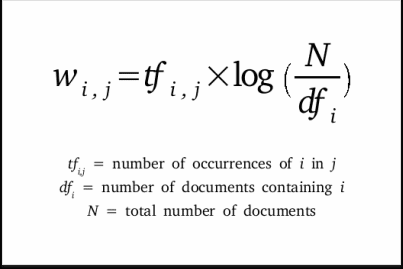

In [ ]:
# Instantiate and fit TfidfVectorizer
tfidf_vect = TfidfVectorizer(analyzer = clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['body_text'])

# Use fitted TfidfVectorizer to transform body text in X_train and X_test
tfidf_train = tfidf_vect.transform(X_train['body_text'])
tfidf_test = tfidf_vect.transform(X_test['body_text'])

# Recombine transformed body text with body_len and punct% features
X_train = pd.concat([X_train[['body_len', 'punct%']].reset_index(drop = True), pd.DataFrame(tfidf_train.toarray())], axis = 1)
X_test = pd.concat([X_test[['body_len', 'punct%']].reset_index(drop = True), pd.DataFrame(tfidf_test.toarray())], axis = 1)

# Check shape
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

# 6. Modelling

Now that our data is ready, we can finally move on to modelling, that is building a binary classifier to classify a given text as ham or spam.

Here, we will make a **random forest** machine learning model.

## 6.1 RandomForestClassifier

[RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) is an ensemble learning method (bagging) that constructs a collection of decision trees and then aggregates the predictions of each tree to determine the final prediction.

In [ ]:
# Instantiate RandomForestClassifier with optimal set of hyperparameters 
rf = RandomForestClassifier(n_estimators = 50, max_depth = None, random_state = 42, n_jobs = -1)

# Fit model
start = time.time()
rf_model = rf.fit(X_train, Y_train)
end = time.time()
fit_time = end - start

# Predict 
start = time.time()
Y_pred = rf_model.predict(X_test)
end = time.time()
pred_time = end - start

# Time and prediction results
precision, recall, fscore, support = score(Y_test, Y_pred, pos_label = 'spam', average = 'binary')
print(f"Fit time: {round(fit_time, 3)} / Predict time: {round(pred_time, 3)}")
print(f"Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / Accuracy: {round((Y_pred==Y_test).sum() / len(Y_pred), 3)}")

In [ ]:
# Confusion matrix for RandomForestClassifier
matrix = confusion_matrix(Y_test, Y_pred)
sns.heatmap(matrix, annot = True, fmt = 'd')

# Conclusion

To wrap up, we have successfully completed an end-to-end natural language processing (NLP) project which involves building a binary classifier capable of classifying a given text message as spam or ham.

We started off the project by exploring the dataset, followed by feature engineering where we created two new features: *body_len* and *punct%*. We then moved on to performing some preprocessing steps that are specific to the NLP pipeline such as removing punctuations and stopwords, tokenizing and stemming / lemmatization. After that, we performed vectorization using **TfidfVectorizer** in order to encode text and turn them into feature vectors for machine learning. Finally, we were able to build prediction model: **RandomForestClassifier** as well as compute its accuracy and overall performance.
